# Ismétlés előző óráról

- `contextmanager` olyan objektum, ami a `with` statementtel használható:
  
  * van egy `__enter__` és egy `__exit__` metódusa
 
  * legkönnyebben generátor függvényből hozható létre a `@contextmanager` decorátorral.

- Hibakezelés: 
  
  * Hiba jelzése `raise` statementtel
  * Hibajelzés feldolgozása  `try: ... except: ... finally: ...` blokkkal.

- Végignéztük az `itertools` könyvtár függvényeit. Ha sorozatokkal dolgozunk érdemes lehet megnézni, van-e olyan függvénye a könyvtárnak, ami megoldja a feladatunkat.

In [1]:
import time

class Timer:
    def __init__(self):
        self._start = None
        self._elapsed_time = None

    def __enter__(self):
        self._start = time.perf_counter_ns()
        self._elapsed_time = None
        return self

    def __exit__(self, exc_type, exc_value, traceback):
        self._elapsed_time = time.perf_counter_ns() - self._start
        print(f"elapsed_time {self.elapsed_time_ms:.2f} ms")

    @property
    def elapsed_time_ms(self):
        return self._elapsed_time/10**6 if self._elapsed_time else None

# A `functools` könyvtár

Leggyakrabban használt függvények:

- `reduce`: Egy sorozatot redukál egyetlen értékké a megadott függvény segítségével.

- `lru_cache`: Memorizálás. Least Recently Used

- `wraps`: Dekorátorok definiálásakor hasznos. A dekorálandó függvény attribútumait másolja.

- `partial`: Parciális függvény.

## Példák.

#### `reduce` függvény.

In [2]:
import functools
functools.reduce(lambda x, y: x+y, range(5), 0) # (((((0 + 0) + 1) + 2) + 3) + 4) 

10

```python
def reduce(f, seq, initial):
    a = initial 
    for b in seq:
        a = f(a, b)
    return a
```

### `lru_cache` dekorátor

In [5]:
def fibonacci(n):
    if n <= 1:
        return n
    return fibonacci(n-1) + fibonacci(n-2)
# with Timer() as timer:
#     print(f"{fibonacci(30)=}")

In [4]:
@functools.lru_cache(maxsize=50)
def fibonacci(n):
    if n <= 1:
        return n
    return fibonacci(n-1) + fibonacci(n-2)

print(f"without caching {timer.elapsed_time_ms=:.2f} ms")
with Timer():
    print(f"{fibonacci(30)=}")


without caching timer.elapsed_time_ms=186.15 ms
fibonacci(30)=832040
elapsed_time 0.03 ms


### `wraps` dekorátor

In [10]:
def show_call(fun):
    @functools.wraps(fun) # Próbáljuk ki mi történik ha ezt kikommenteljük
    def f(*args):
        result = fun(*args) 
        print(f"{fun.__name__}({', '.join(map(str, args))}) -> {result}")
        return result
    f.__doc__ = "\n\n".join(([fun.__doc__.strip()] if fun.__doc__ else []) + ["This  wrapped function also shows the call"])
    return f

@show_call
def add(a: int, b: int) -> int:
    """adds two number"""
    return a+b 

help(add)
add(1,1)

Help on function add in module __main__:

add(a: int, b: int) -> int
    adds two number
    
    This  wrapped function also shows the call

add(1, 1) -> 2


2

### `partial` 

In [11]:
def f(a, b):
    return a+b

inc1 = functools.partial(f, b=1)
inc1(2)

3

**HF** volt a mai órára. Mi történik a következő kódrészletben? 

In [12]:
import sys
import textwrap
from functools import wraps
from contextlib import contextmanager

def add_indent(write, indentation):
    @wraps(write)
    def f(string):
        return write(textwrap.indent(string, indentation))
    return f

@contextmanager
def indented(indentation):
    try:
        sys.stdout.write = add_indent(sys.stdout.write, indentation)
        yield
    finally:
        sys.stdout.write = sys.stdout.write.__wrapped__

In [13]:
with indented("|---"):
    print("alma\nkorte")
    with indented("|-> "):
        print("alma\nkorte")
    print("alma\nkorte")

print("alma\nkorte")

|---alma
|---korte
|---|-> alma
|---|-> korte
|---alma
|---korte
alma
korte


# Néhány szöveges fileformátum

`json` és `yaml`

- `json` ,,javascript object notation''. Hasonló ahhoz, amit `list`, `dict` esetén a képernyőn látunk. 
  Nem lehet mindent típust `json`-fileba menteni, de a legfontosabbakat igen:
   
  * `int`, `float`, `str`, `bool`
  * `list`, `dict`.

  `json` fileban nincs kommentelési lehetőség.

- `yaml`. Több típust tud kezelni, ezért alapból nem `safe`, de könnyen olvasható, szerkeszthető, lehetnek kommentek is. 

In [14]:
import json

data = [
    {'a': 1, 'b':True, 'pi': .314, "nested": {"c": 3}},
    23,
    [1, 2, 3]
]

json.dumps(data)

'[{"a": 1, "b": true, "pi": 0.314, "nested": {"c": 3}}, 23, [1, 2, 3]]'

In [15]:
# fileba írás
with open("/tmp/test.json", "w") as f:
    json.dump(data, f)

In [16]:
with open("/tmp/test.json", "r") as f:
    print(json.load(f))

[{'a': 1, 'b': True, 'pi': 0.314, 'nested': {'c': 3}}, 23, [1, 2, 3]]


In [17]:
import yaml

print(yaml.dump(data))
# vagy
with open("/tmp/test.yaml", "w") as f:
    yaml.dump(data, f)
    
with open("/tmp/test.yaml", "r") as f:
    print(yaml.safe_load(f))

- a: 1
  b: true
  nested:
    c: 3
  pi: 0.314
- 23
- - 1
  - 2
  - 3

[{'a': 1, 'b': True, 'nested': {'c': 3}, 'pi': 0.314}, 23, [1, 2, 3]]


# Adatok beolvasás internet címről

Itt csak azzal foglalkozunk, hogy egy adott internet címen elérhető file-t akarunk letölteni beépített modul használatával.

Ez az `urllib.request` modullal megoldható.

Hasonló (de nem beépített) modulok:

- `requests`
- `urllib3`

Adott esetben ezeket is érdemes lehet megnézni.

In [18]:
import urllib.request as request

url = "https://www.gutenberg.org/files/1342/1342-0.txt" # Pride and prejudice,
url = "https://www.gutenberg.org/ebooks/67098.txt.utf-8" # Winnie the pooh

with request.urlopen(url) as file:
    btext = file.read()

print(type(btext)) # a letöltött szöveg byteokban van
text = btext.decode("utf-8") # átkonvertáljuk szöveggé
print(type(text))

<class 'bytes'>
<class 'str'>


In [19]:
print(*text.splitlines()[110:120], sep="\n")

                              INTRODUCTION

If you happen to have read another book about Christopher Robin, you may
remember that he once had a swan (or the swan had Christopher Robin, I
don't know which) and that he used to call this swan Pooh. That was a
long time ago, and when we said good-bye, we took the name with us, as
we didn't think the swan would want it any more. Well, when Edward Bear
said that he would like an exciting name all to himself, Christopher
Robin said at once, without stopping to think, that he was
Winnie-the-Pooh. And he was. So, as I have explained the Pooh part, I


# Milyen további beépített modulok vannak Pythonban?

[The Python Standard Library](https://docs.python.org/3.10/library/index.html)

A leggyakrabban használtak:

* datetime (dátumok, idő reprezentálása)

Pl. 1000 nap múlva hányadika lesz?

In [20]:
from datetime import datetime, timedelta


later = datetime.now() + timedelta(days=1000)
later

datetime.datetime(2027, 8, 1, 8, 50, 51, 600399)

* **`itertools`** (iterátorok, "lusta kiértékelésű" adatszerkezetek)

* **`collections`** (néhány adatszerkezet)

* **`json`** (json formátumú fájlok olvasása/írása)

* **`datetime`** (dátumok, idő reprezentálása)

* **`math`** (matematikai függvények)

* **`random`** (véletlenszámok valamilyen eloszlásból)

* **`pathlib`** (fájl és folder elérési utak kezelése)

* **`os`** (operációs rendszerhez kapcsolódó függvények)

* **`csv`** (csv-formátumú fájlok írása/olvasása)

és még egy csomó más (`sys`, `multiprocessing`, `time`, `dataclasses`, `io`, `gzip`, `tarfile`, `tempfile`, `copy`, `heapq`, `bisect`, `functools`, etc.)

Ezenkívül vannak azok a könyvtárak, amelyek nem részei a standard library-nek, de valamilyen csomagkezelővel installálhatók (pl. pip-pel).

* **numpy** (lineáris algebra, mátrixok, vektorok)
* **scipy** (mérnöki számítások, jelfeldolgozás, differenciálegyenletek, integrálás, interpoláció, stb)
* **pandas** (táblázatos adatok manipulációja, kezelése, ezeken való számítások)
* **matplotlib** (vizualizáció)
* **scikit-learn** (gépi tanulás könyvtár)


* **tensorflow** (a Google által fejlesztett deep learning könyvtár)
* **pytorch** (a Facebook által fejlesztett deep learning könyvtár)


* **pyspark** (elosztott számításokra alkalmas gépi tanulás könyvtár)


* **nltk** (természetesnyelv-feldolgozás könyvtár, NLP)
* **spacy** (természetesnyelv-feldolgozás könyvtár, NLP)

# OOP - öröklődés (inheritance)

Ezt a témát csak röviden érintjük. A nagy OOP nyelvekben az öröklődés egy központi jelentőségű téma, de itt most ezen az órán csak érintőlegesen beszélünk róla.

Gyakran fordul elő olyan helyzet, amikor valamilyen hierarchiába rendezhető osztályaink vannak. Pl. lehet egy `Person` osztályunk, amely emberekről tárol valamilyen attribútumokat, és lehet egy `Student` osztály is, amely hallgatók adatait tárolja. Mivel minden `Student` egyben egy `Person` is, ezért a `Person`-ban definiált attribútumok, metódusok egyben minden `Student` számára értelmesek, és ezeket nem kell újra definiálnunk, hanem megmondhatjuk, hogy a `Student` osztály örökölje meg a `Person` osztály metódusait.

Arra is van lehetőség, hogy a megörökölt metódusokat az adott al-osztályban (subclass) felülírjuk (override).

Az első rövid példánkban a téglalapokat tároló `Rectangle` osztályt definiáljuk, melynek van egy `area` property-je. Minden négyzet egyben egy téglalap, ezért a négyzeteket tároló `Square` osztály leszármazik a `Rectangle` osztályból.

In [22]:
class Rectangle:
    def __init__(self, width, height):
        self.width = width
        self.height = height    
    @property
    def area(self):
        return self.width * self.height
class Square(Rectangle):
    def __init__(self, side_length):
        pass

In [24]:
s = Square(10)
s.area

AttributeError: 'Square' object has no attribute 'width'

In [25]:
# Meg kell hívni az szülő-osztály __init__ metódusát

class Square(Rectangle):
    def __init__(self, side_length):
        super().__init__(side_length, side_length)

In [26]:
s = Square(10)

s.area

100

In [28]:
class Rectangle:
    def __init__(self, width, height):
        self.width = width
        self.height = height
        
    def __repr__(self):
        return f"{type(self).__name__}({self.width}, {self.height})"
        
    @property
    def area(self):
        return self.width * self.height
    
class Square(Rectangle):
    def __init__(self, side_length):
        super().__init__(side_length, side_length)

In [30]:
s = Square(10)
s
Rectangle(3,2)

Rectangle(3, 2)

In [31]:
class Rectangle:
    def __init__(self, width, height):
        self.width = width
        self.height = height
        
    def __repr__(self):
        return f"{type(self).__name__}({self.width}, {self.height})"
        
    @property
    def area(self):
        return self.width * self.height
    
class Square(Rectangle):
    def __init__(self, side_length):
        super().__init__(side_length, side_length)
        
    def __repr__(self):
        return f"{type(self).__name__}({self.width})"

In [32]:
r = Rectangle(10, 20)
print(r.area)
print(r)


s = Square(10)
print(s.area)
print(s)

200
Rectangle(10, 20)
100
Square(10)


In [34]:
print(type(s))

print(f"{isinstance(s, Square)=}")
print(f"{isinstance(s, Rectangle)=}")

print(issubclass(Square, Rectangle))

<class '__main__.Square'>
isinstance(s, Square)=True
isinstance(s, Rectangle)=True
True


A beépített adatszerkezeteknél is láthatunk öröklődést. Például a korábban látott `Counter` osztály definíciója így kezdődik:
```python
class Counter(dict):
    pass
```
azaz a `Counter` osztály leszármazik a `dict` osztályból, vagyis egy Counter egyben egy `dict` is. Pythonban lehetséges a többszörös öröklődés is, azonban ebbe az irányba már nem megyünk tovább.

# Mátrixok és vektorok (Matrices and vectors)

A következőkben a legfontosabb, tudományos számításokra használt könyvtárakat tekintjük át.

* numpy
* matplotlib
* pandas


Elsőként a Numpy-al foglakozunk, ami a legalapvetőbb lineáris algebrai könyvtár. Ezek a könyvtárak a hatékonyság miatt elsősorban `C/C++`, esetleg Cython-ban implementált függvényekre támaszkodnak, vagyis itt valójában `C`-szerűen tárolt vektorokról lesz szó, amelyeken lényegében `C/C++` függvények hívódnak meg, mindezt elrejtve a felhasználó elől, Python függvényhívások mögé.

A numpy nem része a Python standard library-nek, azaz installálni kell. Ha `colab`-on dolgozunk, vagy Anaconda csomagkezelőnk van, akkor a numpy már valószínűleg telepítve van, egyébként pedig a Python saját `pip` csomagkezelőjével lehet telepíteni, a 

```
pip install numpy
```
paranccsal. Megadott verziószámú csomagot is lehet telepíteni, ha szükséges.

```
pip install numpy==1.26.4
```

In [35]:
# A numpy importálására az alábbi konvenciót szokás használni.

import numpy as np

A Numpy alapvető adatszerkezete az `ndarray`, ami egy $N$-dimenziós, azonos típusú elemeket tartalmazó, fix méretű tömb.

Típus alatt itt elsősorban a C-ből ismert numerikus típusokat értjük, noha lehetséges sztringeket is ilyen tömbbe tenni. Egy Python lista Python objektumokat tartalmaz, amelyek össze-vissza lehetnek a memóriában, ezzel szemben egy C-tömb (kihasználva, hogy minden elemének ugyanaz a típusa) a memóriának egy összefüggő területét foglalja el.

```
np.float_, np.float32, np.float64, ...
np.int_, np.int32, np.int64, ...
np.bool_
```

Itt a hatékonyság kedvéért le kell mondanunk a tetszőleges hosszúságú Python egészekről.

### Egydimenziós tömbök konstruálása

In [48]:
# # Tömbök konstruálása
# v = np.array([1, 1, 2, 3, 5, 8])
# v

In [50]:
# v.dtype

In [51]:
v = np.array([1, 1, 2, 3, 5, 8], dtype=np.float_)

In [55]:
# v.dtype

In [54]:
# len(v)

In [53]:
# v.shape

In [57]:
# logikai tömb / boolean array
# np.array([0, 1, 0, 0, 1], dtype=np.bool_)

In [58]:
# Explicit type cast
v = np.array([0, 1, 0, 0, 1], dtype=np.int_)
print(repr(v.astype(np.bool_)))
print(repr(v.astype("float32")))

array([False,  True, False, False,  True])
array([0., 1., 0., 0., 1.], dtype=float32)


### Többdimenziós tömbök konstruálása

In [59]:
# az elemeket listák listájaként adhatjuk meg
matrix = np.array([[1, 2, 3], [4, 5, 6]])
matrix

array([[1, 2, 3],
       [4, 5, 6]])

In [60]:
matrix.ndim

2

In [63]:
matrix.shape
matrix.size

6

In [77]:
# Speciális mátrix konstrukciók
A = np.zeros(shape=(3, 3), dtype=np.int_)

In [75]:
B = np.ones(shape=(3, 5), dtype=np.float_)

In [68]:
I = np.identity(3)

In [72]:
I = np.eye(4, 3, dtype=np.int_)

In [74]:
np.arange(10)

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

In [76]:
np.linspace(0, 1, 11)

array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ])

In [78]:
v = np.array([1, 2, 4, 9, -1], dtype=np.float32)
np.zeros_like(v) 

array([0., 0., 0., 0., 0.], dtype=float32)

## Algebrai műveletek

In [79]:
A = np.array([[1, 2, 3], [4, 5, 6]])

In [85]:
# 2 * A

In [86]:
#2.0 * A

In [88]:
# -A

In [89]:
# elemenkénti összeadás
# np.add(A, A)

In [91]:
# A + A

In [94]:
# elemenkénti szorzás
# np.multiply(A, A)

In [95]:
#A * A

In [97]:
# 2 * np.ones_like(A)

In [98]:
# elemenkénti osztás
np.divide(A, B)

array([[0.5, 1. , 1.5],
       [2. , 2.5, 3. ]])

In [100]:
A // B

array([[0, 1, 1],
       [2, 2, 3]])

## Mátrix, vektor műveletek

- mátrix szorzás: `matmul`, (`@`), `dot`.
- tenzoriális szorzás: `tensordot`
- Einstein szummáció: `einsum`

In [101]:
b = np.array([1, 2, 3])
print(A.shape)
print(b.shape)

(2, 3)
(3,)


In [102]:
# Mátrix-vektor szorzás

np.matmul(A, b)

array([14, 32])

In [103]:
A @ b

array([14, 32])

Különböző dimenziójú mátrixokkal való műveletek esetén legyünk óvatosak, győződjünk meg arról, hogy az történik, amit szeretnénk.

In [104]:
# Igazából ez lenne a helyes mátrixszorzás, megfelelő dimenziószámmal
print(A)
b = np.expand_dims(np.array([1, 2, 3]), 1)
b

[[1 2 3]
 [4 5 6]]


array([[1],
       [2],
       [3]])

In [105]:
C = np.matmul(A, b)

print(C.shape)
C

(2, 1)


array([[14],
       [32]])

In [106]:
A

array([[1, 2, 3],
       [4, 5, 6]])

In [107]:
b = np.array([1, 2, 3])
b

array([1, 2, 3])

In [108]:
A / b

array([[1. , 1. , 1. ],
       [4. , 2.5, 2. ]])

In [109]:
A * b

array([[ 1,  4,  9],
       [ 4, 10, 18]])

A fenti két művelet elementkénti osztás és szorzás, és azért tud végrehajtódni, mert a $b$-ből két példányt véve le tudjuk fedni az $A$ dimenzióját, azaz a $b$ vektor automatikusan kiegészítődőtt saját maga másolatával úgy, hogy a mérete megegyezzen az $A$ méretével (**broadcasting**). A $b = [1, 2, 3]$, egydimenziós $(3,)$ méretű vektorból implicit módon egy $(1, 3)$-mas, ebből pedig egy kétdimenziós, $(2, 3)$-as tömb lett.

In [110]:
v = np.array([[1], [11]])
w = np.array([1, 2, 3, 4, 5, 6])
print(v.shape)
print(w.shape)
w + v

(2, 1)
(6,)


array([[ 2,  3,  4,  5,  6,  7],
       [12, 13, 14, 15, 16, 17]])

### `broadcasting` néhány példán keresztül

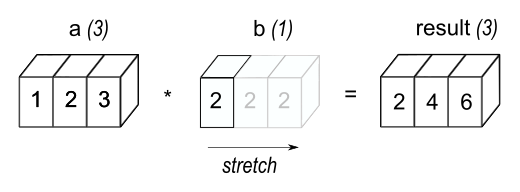

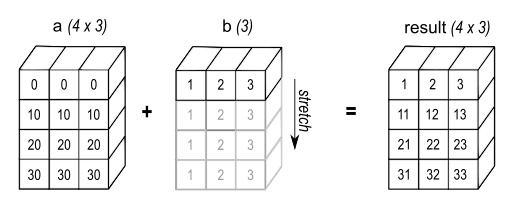

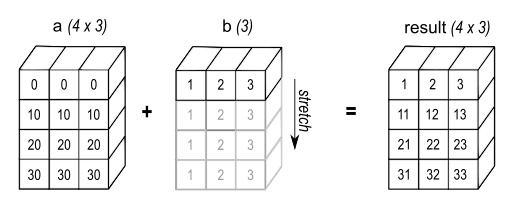

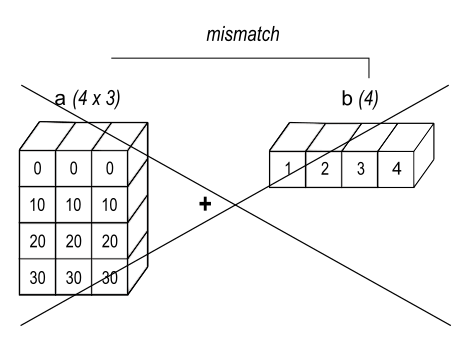

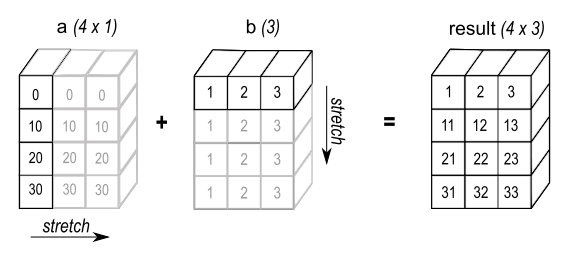

### Indexelés (indexing)

In [143]:
A = np.array([[1, 2, 3, 4, 5], [10, 20, 30, 40, 50], [9, 8, 7, 6, 5], [1, 0, 1, 0, 1]])

In [129]:
# A[1]

In [130]:
# A[1][2]

In [131]:
# A[1, 2]

In [122]:
# A[:2, 1:4]

In [121]:
# A[:2, :]

In [136]:
# A[0, 0:3] = -1 ; A

In [132]:
# np.array_equal(A, A)

In [137]:
# A[A <= 0] = -100 ; A

In [139]:
# np.where(A == 100, 0, 1)

In [141]:
# np.where(A == 100, -A, 2*A)

In [144]:
A[[1, 3]]

array([[10, 20, 30, 40, 50],
       [ 1,  0,  1,  0,  1]])

In [145]:
A[:, [1, 3]] 

array([[ 2,  4],
       [20, 40],
       [ 8,  6],
       [ 0,  0]])

In [ ]:
A[:, [4, 2, 0]]

### Vektorizált elemenkénti függvények (Vectorized element-wise functions)

In [146]:
v = np.arange(5)

v

array([0, 1, 2, 3, 4])

In [147]:
np.square(v)

array([ 0,  1,  4,  9, 16])

In [148]:
np.sin(A)

array([[ 0.84147098,  0.90929743,  0.14112001, -0.7568025 , -0.95892427],
       [-0.54402111,  0.91294525, -0.98803162,  0.74511316, -0.26237485],
       [ 0.41211849,  0.98935825,  0.6569866 , -0.2794155 , -0.95892427],
       [ 0.84147098,  0.        ,  0.84147098,  0.        ,  0.84147098]])

In [149]:
np.exp(A)

array([[2.71828183e+00, 7.38905610e+00, 2.00855369e+01, 5.45981500e+01,
        1.48413159e+02],
       [2.20264658e+04, 4.85165195e+08, 1.06864746e+13, 2.35385267e+17,
        5.18470553e+21],
       [8.10308393e+03, 2.98095799e+03, 1.09663316e+03, 4.03428793e+02,
        1.48413159e+02],
       [2.71828183e+00, 1.00000000e+00, 2.71828183e+00, 1.00000000e+00,
        2.71828183e+00]])

In [150]:
np.log(A)

/tmp/ipykernel_2182135/2475394391.py:1: RuntimeWarning: divide by zero encountered in log
  np.log(A)


array([[0.        , 0.69314718, 1.09861229, 1.38629436, 1.60943791],
       [2.30258509, 2.99573227, 3.40119738, 3.68887945, 3.91202301],
       [2.19722458, 2.07944154, 1.94591015, 1.79175947, 1.60943791],
       [0.        ,       -inf, 0.        ,       -inf, 0.        ]])

## Néhány tömb művelet

In [163]:
# np.sum(v), v.sum(), v

In [154]:
import numpy as np
np.random.seed(123)
lst = np.random.randint(-1000, 1000, 1_000_000).tolist()

In [156]:
# %timeit -n 100 s = sum(lst) # így is mérhetünk futási időt

10 ms ± 50.4 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [157]:
v = np.array(lst, dtype=np.int32)
%timeit -n 100 s = np.sum(v) 

320 µs ± 12.2 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [159]:
v = np.arange(30)
A = np.reshape(v, (5, 6))    # vagy v.reshape(5, 6)
# A

In [162]:
A.sum(axis=1)

array([ 15,  51,  87, 123, 159])

In [ ]:
A = np.arange(15).reshape(3, 5)

B = np.zeros(shape=(3, 5), dtype=np.int_)

In [ ]:
# np.vstack((A, B))

np.concatenate((A, B), axis=0)

In [ ]:
# np.hstack((A, B))

np.concatenate((A, B), axis=1)

### Egyszerűbb statisztikai függvények

In [ ]:
v = np.array([1, 4, 3, 5, 35, 0, -1, 2])

v

$$
\overline v \equiv \text{mean}(v) = \frac{\sum_{i=1}^n v_i}{n}
$$


$$
\text{std}(v) = \sqrt{\frac{\sum_{i=1}^n (v_i - \overline{v})^2}{n}}
$$

In [ ]:
print(v)

print(f"összeg: {np.sum(v)}")

print(f"átlag: {np.mean(v):.2f}")

print(f"medián: {np.median(v)}")

print(f"szórás: {np.std(v):.2f}")

print(f"szórásnégyzet (variancia): {np.var(v):.2f}")

In [ ]:
A = np.array([
    [1, 2, 3],
    [10, 11, 12],
    [0, 3, 1],
    [10, -5, 1]
])

A

In [ ]:
# A.sum()

np.sum(A)

In [ ]:
# Elemek abszolútértékeinek összege

np.sum(np.abs(A))

In [ ]:
# elemek átlaga

np.mean(A)

In [ ]:
# elemek szórása

np.std(A)

In [ ]:
# elemek szórásnégyzete

np.var(A)

Többdimenziós tömböknél azonban érdekelhet minket a sorösszeg / oszlopösszeg, a sorátlag / oszlopátlag, stb. is.

In [ ]:
print(A.shape)

# ez tehát az oszlopösszeg
np.sum(A, axis=0)

In [ ]:
print(np.sum(A[1, :]))

# ez a sorösszeg
np.sum(A, axis=1)

In [ ]:
# A keletkező vektor egyik dimenziója azonban eltűnt, a sorösszeg egy 1-dimenziós vektor lett

row_sums = np.sum(A, axis=1, keepdims=True)

print(row_sums.shape)

row_sums

In [ ]:
# Hasonlóan, oszlopátlagot is számolhatunk

np.mean(A, axis=0)

In [ ]:
A

In [ ]:
# melyik tengely mentén rendez a `sort`, ha nem adunk meg semmit?

np.sort(A)

In [ ]:
np.sort(A, axis=0)

In [ ]:
help(np.sort)